In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from MPyDATA_examples.Olesik_et_al_2020.setup import Setup
from MPyDATA_examples.Olesik_et_al_2020.demo_plot_convergence  import plot
from MPyDATA_examples.Olesik_et_al_2020.coordinates import x_id, x_p2, x_p3, x_log_of_pn
from MPyDATA.options import Options
from MPyDATA_examples.Olesik_et_al_2020.simulation import Simulation
# from MPyDATA_examples.Olesik_et_al_2020.analysis import analysis


In [13]:
GCs = np.linspace(.05,.95, 5)
nrs = np.linspace(32,128,5, dtype = int)

In [14]:
from joblib import Parallel, parallel_backend, delayed

In [15]:
grid_layout = x_id()
psi_coord = x_p2()
options = Options(n_iters=2,infinite_gauge=False, flux_corrected_transport=True,third_order_terms=False)
setup = Setup()

In [16]:
from MPyDATA_examples.Olesik_et_al_2020.physics.equilibrium_drop_growth import PdfEvolver
from MPyDATA.arakawa_c.discretisation import discretised_analytical_solution
from MPyDATA_examples.utils.error_norms import L2


In [25]:
def analysis(nr, GC):
    setup = Setup(nr = nr, mixing_ratios_g_kg = [1,1.2])
    simulation = Simulation(setup, grid_layout,  psi_coord, options, GC)
    t = simulation.out_steps[-1] * simulation.dt
    rh = simulation.rh
    pdf_t = PdfEvolver(setup.pdf, setup.drdt, t)
    analytical = discretised_analytical_solution(
                simulation.rh.magnitude,
                lambda r: pdf_t(r * rh.units).magnitude
            ) * pdf_t(rh[0]).units
    numerical = simulation.n
    loc_of_maximum = np.argmax(numerical)
    maximum = np.max(numerical)
    mean = np.mean(numerical)
    std = np.std(numerical)
#     descriptive = {'max':maximum, 'loc_of_maximum':loc_of_maximum,'mean':mean,'std':std}
    error_L2 = L2(numerical.magnitude, analytical.magnitude, simulation.out_steps[-1])
    return nr, GC, error_L2 , maximum, loc_of_maximum, mean, std

In [54]:
with parallel_backend('threading', n_jobs=-2):
    results0 = Parallel(verbose=10)(
        delayed(analysis)(nr, GC)
        for nr in nrs
        for GC in GCs
    )

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-2)]: Done  15 out of  25 | elapsed:   57.3s remaining:   38.2s
[Parallel(n_jobs=-2)]: Done  18 out of  25 | elapsed:  1.1min remaining:   25.7s
[Parallel(n_jobs=-2)]: Done  21 out of  25 | elapsed:  1.3min remaining:   15.2s
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed:  1.4min finished


In [67]:
# results = np.array(results).T
results = [list(i) for i in zip(*results0)]
descriptive = {'max':results[3], 'loc_of_maximum':results[4],'mean':results[5],'std':results[6]}
results = np.array(results[0:3])

(1600, 1600)


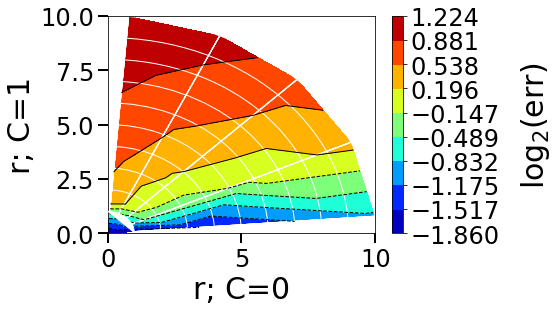

In [69]:
plot(results[0], results[1], results[2])

In [68]:
descriptive['max']

[69.34551867131783 <Unit('1 / centimeter ** 3 / micrometer')>,
 69.34551867131783 <Unit('1 / centimeter ** 3 / micrometer')>,
 69.34551867131783 <Unit('1 / centimeter ** 3 / micrometer')>,
 69.34551867131783 <Unit('1 / centimeter ** 3 / micrometer')>,
 69.34551867131783 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.3227109713023 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.3227109713023 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.3227109713023 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.3227109713023 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.3227109713023 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.51251792874761 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.51251792874761 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.51251792874761 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.51251792874761 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.51251792874761 <Unit('1 / centimeter ** 3 / micrometer')>,
 70.54177443462137 <Unit('1 / centimeter ** 3 / micrometer')